In [ ]:
!unzip /content/drive/MyDrive/firstdataBoobs.zip

Streaming output truncated to the last 5000 lines.
  inflating: firstdata/ pink long sleeve shirt/9.txt  
  inflating: firstdata/ pink long sleeve shirt/8.txt  
  inflating: firstdata/ pink long sleeve shirt/10.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._10.png  
  inflating: firstdata/ pink long sleeve shirt/6.txt  
  inflating: firstdata/ pink long sleeve shirt/7.txt  
  inflating: firstdata/ pink long sleeve shirt/3.txt  
  inflating: firstdata/ pink long sleeve shirt/2.txt  
  inflating: firstdata/ pink long sleeve shirt/1.txt  
  inflating: firstdata/ pink long sleeve shirt/7.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._7.png  
  inflating: firstdata/ pink long sleeve shirt/6.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._6.png  
  inflating: firstdata/ pink long sleeve shirt/2.png  
  inflating: __MACOSX/firstdata/ pink long sleeve shirt/._2.png  
  inflating: firstdata/ pink long sleeve shirt/3.png  
  inflating: __MACOSX/f

In [ ]:
!unzip /content/drive/MyDrive/prequet.zip

Archive:  /content/drive/MyDrive/prequet.zip
  inflating: train_data_processed.parquet  
  inflating: validate_data_processed.parquet  
  inflating: test_data_processed.parquet  


In [ ]:
!pip install datasets
!pip install bitsandbytes
!pip install peft
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9799059ecc0b360d980750e8477e3e7816eab4a7563b4d7d1cb15696f4df1cae
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from transformers.models.gpt2.modeling_gpt2 import CausalLMOutputWithCrossAttentions

In [ ]:
#import utils as plh

#base_path = plh.get_project_root()
#Pandas
from pandas import read_parquet

#HuggingFace: Dataset Library
from datasets import Dataset
from datasets import Image

#General Library
import os
import gc

def get_dataset(filetype, **kargs):

    """
    Create dataset based on file
    """

    filepath = ""
    data_sample = -1

    #Read data
    if filetype == 'train':

        filepath = kargs["train_filepath"]
        data_sample = kargs["train_sample"]

    elif filetype == 'valid':

        filepath = kargs["valid_filepath"]
        data_sample = kargs["valid_sample"]

    elif filetype == 'test':

        filepath = kargs["test_filepath"]
        data_sample = kargs["test_sample"]

    if len(filepath) == 0:
        return

    seed = kargs["seed"]
    image_base_path = kargs["image_base_path"]

    #print(f'Reading file from path: "{filepath}"')
    db_set = read_parquet(filepath)

    if data_sample != -1:
        db_set = db_set.sample(n = data_sample, random_state = seed)

    image_paths = list(image_base_path + '/' + db_set["image_name"])
    captions = list(db_set["title"])

    del [db_set]

    db_set = Dataset.from_dict(
        {
            "image": image_paths,
            "text": captions,
        }
    ).cast_column("image", Image())

    del [image_paths, captions]
    gc.collect()

    return db_set

In [ ]:
# train_shape = read_parquet('/content/DIP/train_data_processed.parquet')
# valid_shape = read_parquet('/content/DIP/validate_data_processed.parquet')
# test_shape = read_parquet('/content/DIP/test_data_processed.parquet')
train_shape = read_parquet('/content/train_data_processed.parquet')
valid_shape = read_parquet('/content/validate_data_processed.parquet')
test_shape = read_parquet('/content/test_data_processed.parquet')
print(f"{train_shape.shape}\n{valid_shape.shape}\n{test_shape.shape}")

(11655, 3)
(1227, 3)
(68, 3)


In [ ]:
 import tensorflow as tf
 print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
 gpus = tf.config.list_logical_devices('GPU')
 strategy = tf.distribute.MirroredStrategy(gpus)

Num GPUs Available:  1


In [ ]:
train_dbset = get_dataset(filetype = 'train',
                          seed = 44,
                          train_filepath = os.path.join('/content', 'train_data_processed.parquet'),
                          train_sample = 11655,
                          image_base_path = os.path.join('/content','firstdata', 'Thesis_Doodle_Files'),
                         )

In [ ]:
valid_dbset = get_dataset(filetype = 'valid',
                          seed = 44,
                          valid_filepath = os.path.join('/content', 'validate_data_processed.parquet'),
                          valid_sample = 1227,
                          image_base_path = os.path.join('/content','firstdata', 'Thesis_Doodle_Files'),
                         )

In [ ]:
test_dbset = get_dataset(filetype = 'test',
                          seed = 44,
                          test_filepath = os.path.join('/content', 'test_data_processed.parquet'),
                          test_sample = 68,
                          image_base_path = os.path.join('/content','firstdata', 'Thesis_Doodle_Files'),
                         )

In [ ]:
train_dbset[0]["text"]

'shoulder off crop purple top'

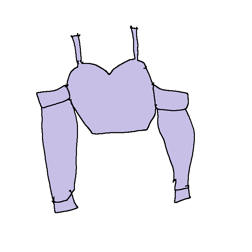

In [ ]:
train_dbset[0]["image"].resize((252,252))

In [ ]:
from torch.utils.data import Dataset, DataLoader
from keras.metrics import Accuracy

class ImageCaptioningDataset(Dataset):

    def __init__(self, dataset, processor):

        self.dataset = dataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        encoding = self.processor(images = item["image"],#.resize(self.new_size),
                                  #padding = "max_length",
                                  return_tensors = "pt"
                                 )

        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]

        return encoding

def collate_fn(batch):

    # pad the input_ids and attention_mask
    processed_batch = {}

    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                                            [example["text"] for example in batch],
                                            padding = "max_length" ,#True,
                                            max_length = 13, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)
BATCH_SIZE = 32

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [ ]:
train_dataloader = DataLoader(ImageCaptioningDataset(train_dbset, processor),
                              shuffle = True,
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor  = 2,
                             )

del train_dbset


In [ ]:
valid_dataloader = DataLoader(ImageCaptioningDataset(valid_dbset, processor),
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del valid_dbset

In [ ]:
test_dataloader = DataLoader(ImageCaptioningDataset(test_dbset , processor),
                              batch_size = BATCH_SIZE,
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del test_dbset

In [ ]:
gc.collect()

48

In [ ]:
from accelerate import Accelerator
#device = "cuda" if torch.cuda.is_available() else "cpu"
accelerator = Accelerator()
device = accelerator.device
print(f'Device: {device}')

Device: cuda


In [ ]:
# from transformers import Blip2ForConditionalGeneration
# import torch

# device_map = {
#     "query_tokens": 0,
#     "vision_model":0,
#     "language_model": 1,
#     "language_projection": 1,
#     "lm_head": 1,
#     "qformer": 0,
# }
# max_memory = {i: "4GB" for i in range(2)} #2 GPU

# model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded",
#                                                       device_map = device_map,  #"auto", # "balanced_low_0"
#                                                       max_memory = max_memory,
#                                                       load_in_8bit = True,
#                                                       torch_dtype = torch.float16,
#                                                      )

from transformers import Blip2ForConditionalGeneration
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU

with strategy.scope():
  model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded").to(device)


config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, get_peft_model
with strategy.scope():
  # Let's define the LoraConfig
  config = LoraConfig(
      r = 16, #32, #10, #18, #16, # Lower rank results in fewer trainable parameters.
      lora_alpha = 32,
      lora_dropout = 0.05,
      bias = "none",
      target_modules = ["q_proj", "k_proj"]
  )

  model = get_peft_model(model, config)

  model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [ ]:
from accelerate import Accelerator
#import torch

lr = 6e-4 #2e-4 #5e-4 #8e-4
with strategy.scope():
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  #model.gradient_checkpointing_enable()

  accelerator = Accelerator()
  model, optimizer, train_dataloader, valid_dataloader  = accelerator.prepare(model, optimizer, train_dataloader, valid_dataloader)

In [ ]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
# device = accelerator.device
# print(f'Device: {device}')

In [ ]:
#Eval metric Library
from rouge_score import rouge_scorer, scoring
from evaluate import load

rouge_types = ["rouge1", "rouge2", "rougeL"]
use_stemmer = False
rouge_score_obj = rouge_scorer.RougeScorer(rouge_types = rouge_types, use_stemmer = use_stemmer)
bleu_score_obj = load("bleu")

def compute_metrics(pred_text, labels_text):

    for ref, pred in zip(labels_text, pred_text):

        #ROUGE Score
        output_score = rouge_score_obj.score(prediction = pred.strip(), target = ref.strip())
        rouge_score_aggregator.add_scores(output_score)

        #BLEU Score
        bleu_score = {}

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 2)
        bleu_score['bleu@2'] = results['bleu']

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 1)
        bleu_score['bleu@1'] = results['bleu']

        bleu_score_aggregator.add_scores(bleu_score)


    agg_bleu = bleu_score_aggregator.aggregate()
    agg_rouge = rouge_score_aggregator.aggregate()

    return {
        #ROUGE metric
        "rouge1_fmeasure": round(agg_rouge['rouge1'].mid.fmeasure, 2),
        "rouge2_fmeasure": round(agg_rouge['rouge2'].mid.fmeasure, 2),
        "rougeL_fmeasure": round(agg_rouge['rougeL'].mid.fmeasure, 2),

        #BLEU metric
        "bleu@1": round(agg_bleu['bleu@1'].mid, 2),
        "bleu@2": round(agg_bleu['bleu@2'].mid, 2),
    }

In [ ]:
from tqdm import tqdm

epoch = 10
gradient_accumulation_steps = 2

train_losses = []  # List to store training losses for each epoch
blip2_scores = {}
with strategy.scope():
  model = model.to(device)
  for epoch in range(epoch):

      print("Epoch:", epoch)

      model.train()
      idx = 0
      epoch_losses = []  # List to store losses for the current epoch

      for batch in tqdm(train_dataloader):

          input_ids = batch.pop("input_ids")
          pixel_values = batch.pop("pixel_values").to(torch.float32)

          outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)

          loss = outputs.loss
          loss = loss / gradient_accumulation_steps

          loss.backward()

          if (idx + 1) % gradient_accumulation_steps == 0:
              optimizer.step()
              optimizer.zero_grad()

              epoch_losses.append(outputs.loss.item() * gradient_accumulation_steps)

          idx += 1

      train_losses.extend(epoch_losses)  # Append losses for the current epoch to the overall list

      # Validation loop
      model.eval()

      rouge_score_aggregator = scoring.BootstrapAggregator()
      bleu_score_aggregator = scoring.BootstrapAggregator()

      for batch in tqdm(valid_dataloader):

          input_ids = batch.pop("input_ids")
          pixel_values = batch.pop("pixel_values").to(torch.float32)

          predictions = model.generate(pixel_values, max_length=10)
          predictions = processor.batch_decode(predictions, skip_special_tokens=True)
          labels = processor.batch_decode(input_ids, skip_special_tokens=True)

          eval_metric = compute_metrics(predictions, labels)

      print(f"Epoch {epoch}: Eval metric on valid dataset:", eval_metric)
      blip2_scores[f"Epoch {epoch}:"] = eval_metric


Epoch: 0


100%|██████████| 39/39 [01:33<00:00,  2.39s/it]


Epoch 0: Eval metric on valid dataset: {'rouge1_fmeasure': 0.4, 'rouge2_fmeasure': 0.11, 'rougeL_fmeasure': 0.37, 'bleu@1': 0.38, 'bleu@2': 0.2}
Epoch: 1


100%|██████████| 39/39 [01:30<00:00,  2.33s/it]


Epoch 1: Eval metric on valid dataset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.38, 'bleu@1': 0.4, 'bleu@2': 0.22}
Epoch: 2


100%|██████████| 39/39 [01:31<00:00,  2.34s/it]


Epoch 2: Eval metric on valid dataset: {'rouge1_fmeasure': 0.43, 'rouge2_fmeasure': 0.15, 'rougeL_fmeasure': 0.4, 'bleu@1': 0.4, 'bleu@2': 0.24}
Epoch: 3


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]


Epoch 3: Eval metric on valid dataset: {'rouge1_fmeasure': 0.44, 'rouge2_fmeasure': 0.16, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.41, 'bleu@2': 0.24}
Epoch: 4


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]


Epoch 4: Eval metric on valid dataset: {'rouge1_fmeasure': 0.46, 'rouge2_fmeasure': 0.19, 'rougeL_fmeasure': 0.43, 'bleu@1': 0.41, 'bleu@2': 0.26}
Epoch: 5


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]


Epoch 5: Eval metric on valid dataset: {'rouge1_fmeasure': 0.46, 'rouge2_fmeasure': 0.2, 'rougeL_fmeasure': 0.44, 'bleu@1': 0.42, 'bleu@2': 0.27}
Epoch: 6


100%|██████████| 39/39 [01:30<00:00,  2.33s/it]


Epoch 6: Eval metric on valid dataset: {'rouge1_fmeasure': 0.48, 'rouge2_fmeasure': 0.22, 'rougeL_fmeasure': 0.46, 'bleu@1': 0.44, 'bleu@2': 0.29}
Epoch: 7


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]


Epoch 7: Eval metric on valid dataset: {'rouge1_fmeasure': 0.48, 'rouge2_fmeasure': 0.22, 'rougeL_fmeasure': 0.45, 'bleu@1': 0.44, 'bleu@2': 0.29}
Epoch: 8


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]


Epoch 8: Eval metric on valid dataset: {'rouge1_fmeasure': 0.5, 'rouge2_fmeasure': 0.24, 'rougeL_fmeasure': 0.47, 'bleu@1': 0.46, 'bleu@2': 0.32}
Epoch: 9


100%|██████████| 39/39 [01:30<00:00,  2.32s/it]

Epoch 9: Eval metric on valid dataset: {'rouge1_fmeasure': 0.5, 'rouge2_fmeasure': 0.25, 'rougeL_fmeasure': 0.48, 'bleu@1': 0.47, 'bleu@2': 0.33}


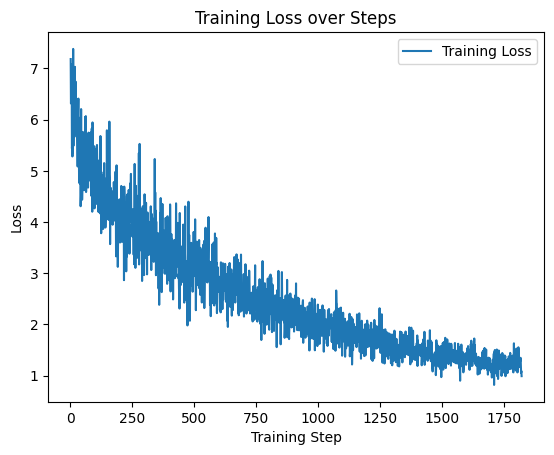

In [ ]:
import matplotlib.pyplot as plt
# Plot the training loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(blip2_scores, orient='index')

print(df)

          rouge1_fmeasure  rouge2_fmeasure  rougeL_fmeasure  bleu@1  bleu@2
Epoch 0:             0.40             0.11             0.37    0.38    0.20
Epoch 1:             0.41             0.13             0.38    0.40    0.22
Epoch 2:             0.43             0.15             0.40    0.40    0.24
Epoch 3:             0.44             0.16             0.41    0.41    0.24
Epoch 4:             0.46             0.19             0.43    0.41    0.26
Epoch 5:             0.46             0.20             0.44    0.42    0.27
Epoch 6:             0.48             0.22             0.46    0.44    0.29
Epoch 7:             0.48             0.22             0.45    0.44    0.29
Epoch 8:             0.50             0.24             0.47    0.46    0.32
Epoch 9:             0.50             0.25             0.48    0.47    0.33


In [ ]:
gc.collect()

210

In [ ]:
# model.save_pretrained(os.join.path(base_path,"content","DIP", 'blip2_visual_peft'))
model.save_pretrained(os.path.join("/content", 'blip2_visual_peft'))

In [ ]:
# from transformers import AutoModelForCausalLM
# from peft import PeftModel, PeftConfig
# #base_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-40b")
# base_model = Blip2ForConditionalGeneration.from_pretrained("/content/blip2_visual_peft")
# peft_model_id = "smangrul/falcon-40B-int4-peft-lora-sfttrainer-sample"
# config = PeftConfig.from_pretrained(base_model,peft_model_id)
# # merged_model = model.merge_and_unload()

In [ ]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
from tqdm import tqdm
import torch

# Specify the path to the uploaded pre-trained PEFT model in Colab
# peft_model_id = "/content/pre-trained-peft-model"

# Load PEFT configuration from the specified model
# config = PeftConfig.from_pretrained(peft_model_id)

# Determine the device to use (cuda if available, otherwise cpu)
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the Blip2 model for conditional generation
with strategy.scope():
  model = Blip2ForConditionalGeneration.from_pretrained(
      "/content/blip2_visual_peft"
  ).to(device)

# Load the PEFT model and combine it with the Blip2 model
#model = PeftModel.from_pretrained(model, peft_model_id)





Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#training
from rouge_score import scoring
rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()
with strategy.scope():
  for batch in tqdm(train_dataloader):

      input_ids = batch.pop("input_ids")#.to(device)
      pixel_values = batch.pop("pixel_values").to(torch.float32)#.to(device)

      predictions = model.generate(pixel_values=pixel_values, max_length = 10)#9 #16
      predictions = processor.batch_decode(predictions, skip_special_tokens = True)
      labels = processor.batch_decode(input_ids, skip_special_tokens = True)

      #print(f'Label: {labels}')
      #print(f'Predictions: {predictions}')

      eval_metric = compute_metrics(predictions, labels)

  print(f"Metric on train dbset:", eval_metric)

100%|██████████| 365/365 [21:39<00:00,  3.56s/it]

Metric on train dbset: {'rouge1_fmeasure': 0.54, 'rouge2_fmeasure': 0.32, 'rougeL_fmeasure': 0.52, 'bleu@1': 0.5, 'bleu@2': 0.39}


In [ ]:
#Valid

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

with strategy.scope():
  for batch in tqdm(valid_dataloader):

      input_ids = batch.pop("input_ids")#.to(device)
      pixel_values = batch.pop("pixel_values").to(torch.float32)#.to(device)

      predictions = model.generate(pixel_values = pixel_values, max_length = 10)#9 #16
      predictions = processor.batch_decode(predictions, skip_special_tokens = True)
      labels = processor.batch_decode(input_ids, skip_special_tokens = True)

      #print(f'Label: {labels}')
      #print(f'Predictions: {predictions}')

      eval_metric = compute_metrics(predictions, labels)

  print(f"Metric on valid dbset:", eval_metric)

100%|██████████| 39/39 [01:31<00:00,  2.35s/it]

Metric on valid dbset: {'rouge1_fmeasure': 0.5, 'rouge2_fmeasure': 0.25, 'rougeL_fmeasure': 0.48, 'bleu@1': 0.47, 'bleu@2': 0.33}


In [ ]:
#test

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()
with strategy.scope():
  for batch in tqdm(test_dataloader):

      input_ids = batch.pop("input_ids")#.to(device)
      pixel_values = batch.pop("pixel_values").to(torch.float32).to(device)

      predictions = model.generate(pixel_values=pixel_values, max_length = 10)#9 #16
      predictions = processor.batch_decode(predictions, skip_special_tokens = True)
      labels = processor.batch_decode(input_ids, skip_special_tokens = True)

      #print(f'Label: {labels}')
      #print(f'Predictions: {predictions}')

      eval_metric = compute_metrics(predictions, labels)

  print(f"Metric on test dbset:", eval_metric)

100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

Metric on test dbset: {'rouge1_fmeasure': 0.48, 'rouge2_fmeasure': 0.26, 'rougeL_fmeasure': 0.45, 'bleu@1': 0.46, 'bleu@2': 0.34}


In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)


Caption: shirt t avengers red logo


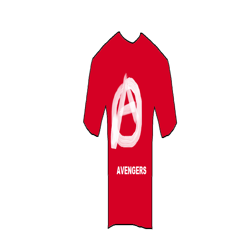

In [ ]:
from PIL import Image

# image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/01d9276f-48ce-47cf-93ed-f86b9fc78dbb.jpeg')
image = Image.open("/content/3.png")

#Inferance on GPU. When used this on GPU will get errors like: "slow_conv2d_cpu" not implemented for 'Half'" , " Input type (float) and bias type (struct c10::Half)"
#inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)

#Inferance on CPU
inputs = processor(images = image, return_tensors = "pt")
pixel_values = inputs.pixel_values.to(device)

generated_ids = model.generate(pixel_values = pixel_values, max_length = 10)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print('Caption: '+ generated_caption)
image.resize((252,252))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
